# Defining notebook settings
Configuration of the smoothing script

In [25]:
# Path to raw PLY files
scandata_dir = '../raw'

# Smoothing fraction
smoothing_fraction = 0.16

# Rendering boxplots before smoothing is enabled
presmoothing_boxplots = True
# Rendering boxplots after smoothing is enabled
postsmoothing_boxplots = True

# Redering of scans before smoothing is enabled
presmoothing_renders = True
# Rendering of scans after smoothing is enabled
postsmoothing_renders = True

# Importing necessary libraries

These are third-party libraries that we used.

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from loess import loess_1d

import os
import open3d as o3d
import sys

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Reading the data
Checking if smoothing was already performed before.

In [ ]:
# Load PLY file names
ply_file_names = os.listdir(scandata_dir)
num_of_clouds = len(ply_file_names)

npy_file_names = [filename for filename in os.listdir('.') if filename.endswith(".npy")]

if (len(ply_file_names) == len(npy_file_names)):
    sys.exit("Smoothing has already deen completed")

Loading PLY files with `open3d`. `open3d` is optimized for handling `.ply` files efficiently. Takes around a minute. There are 3 coordinates (x, y and z) and 22.7 million rows in total.

In [ ]:
# Load PLY files
ply_files = [os.path.join(scandata_dir, f) for f in ply_file_names if f.endswith(".ply")]

# Load point clouds from PLY files and convert them to numpy arrays
point_clouds = [np.asarray(o3d.io.read_point_cloud(ply_file).points).T for ply_file in ply_files]

print(f"Loaded {num_of_clouds} point clouds.")

total_rows = 0
for i in range(num_of_clouds):
    print(f"Point cloud {ply_file_names[i]} shape: {point_clouds[i].shape}")
    total_rows += point_clouds[i].shape[1]
print(f"Total number of rows: {total_rows}")

Loaded 5 point clouds.
Point cloud 221111_144114__binary_onlylines114378to117271.ply shape: (3, 7408640)
Point cloud 221111_144114__binary_onlylines145900to148050.ply shape: (3, 5506560)
Point cloud 221111_144114__binary_onlylines25660to28100.ply shape: (3, 6248960)
Point cloud 221111_144114__binary_onlylines47178to50517.ply shape: (3, 8550400)
Point cloud 221111_144114__binary_onlylines86841to90142.ply shape: (3, 8453120)
Total number of rows: 36167680


The files have millions of rows indicating a missed measurement or no signal. 

In [5]:
total_missing_rows = 0
for i in range(num_of_clouds):
    missing_rows = np.sum(point_clouds[i][2] == 0)
    print(f"Rows with missing measurement in {ply_file_names[i]}: {missing_rows}")
    total_missing_rows += missing_rows
print(f"Total number of rows with missing measurement: {total_missing_rows}")

Rows with missing measurement in 221111_144114__binary_onlylines114378to117271.ply: 1865108
Rows with missing measurement in 221111_144114__binary_onlylines145900to148050.ply: 1720035
Rows with missing measurement in 221111_144114__binary_onlylines25660to28100.ply: 2713280
Rows with missing measurement in 221111_144114__binary_onlylines47178to50517.ply: 5135473
Rows with missing measurement in 221111_144114__binary_onlylines86841to90142.ply: 3735066
Total number of rows with missing measurement: 15168962


These are measurements we want to delete. They don't have value to use and they will only act as (sever) noise to our machine learning models later on.

In [28]:
total_rows = 0
for i in range(num_of_clouds):
    # Find indices of points with missing z coordinate
    z_zero_indices = np.where(point_clouds[i][2] == 0)[0]

    # Delete points with missing measurment
    point_clouds[i] = np.delete(point_clouds[i], z_zero_indices, axis=1)

    print(f"Point cloud {ply_file_names[i]} shape: {point_clouds[i].shape}")
    total_rows += point_clouds[i].shape[1]
print(f"Total number of rows: {total_rows}")

Point cloud 221111_144114__binary_onlylines114378to117271.ply shape: (3, 5543532)
Point cloud 221111_144114__binary_onlylines145900to148050.ply shape: (3, 3786525)
Point cloud 221111_144114__binary_onlylines25660to28100.ply shape: (3, 3535680)
Point cloud 221111_144114__binary_onlylines47178to50517.ply shape: (3, 3414927)
Point cloud 221111_144114__binary_onlylines86841to90142.ply shape: (3, 4718054)
Total number of rows: 20998718


Offesetting scans to start at 0 on X axis.

In [7]:
for i in range(num_of_clouds):
    point_cloud_start_on_x = point_clouds[i][0].min()
    point_clouds[i][0] = point_clouds[i][0] - point_cloud_start_on_x
    print(f"Point cloud {ply_file_names[i]} moved from x={point_cloud_start_on_x} to x=0")

Point cloud 221111_144114__binary_onlylines114378to117271.ply moved from x=114378.0 to x=0
Point cloud 221111_144114__binary_onlylines145900to148050.ply moved from x=145900.0 to x=0
Point cloud 221111_144114__binary_onlylines25660to28100.ply moved from x=25660.0 to x=0
Point cloud 221111_144114__binary_onlylines47178to50517.ply moved from x=47178.0 to x=0
Point cloud 221111_144114__binary_onlylines86841to90142.ply moved from x=86841.0 to x=0


# Preliminary exploration
Let's create a few plots to look at our data and how it is distributed.

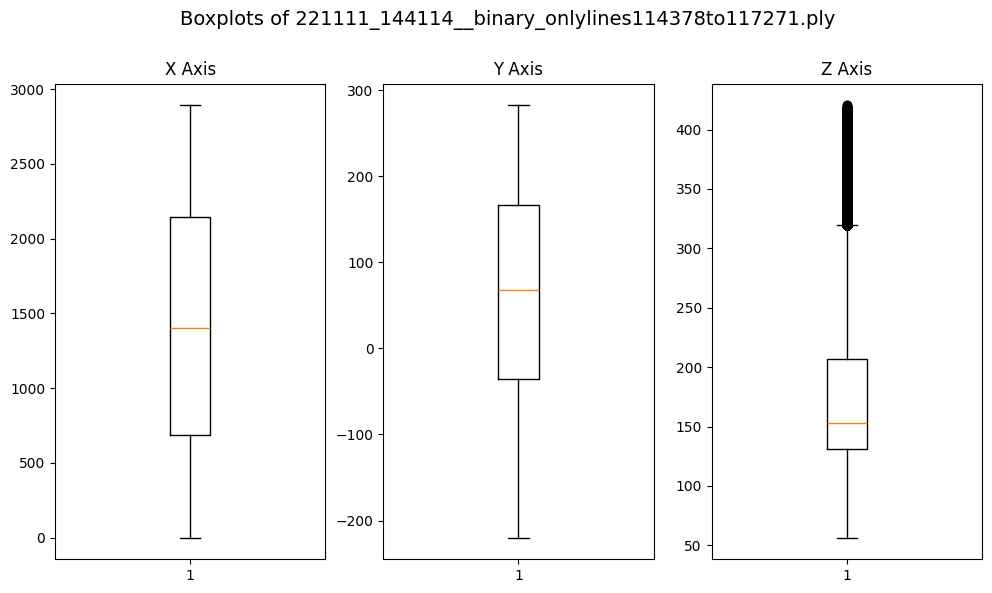

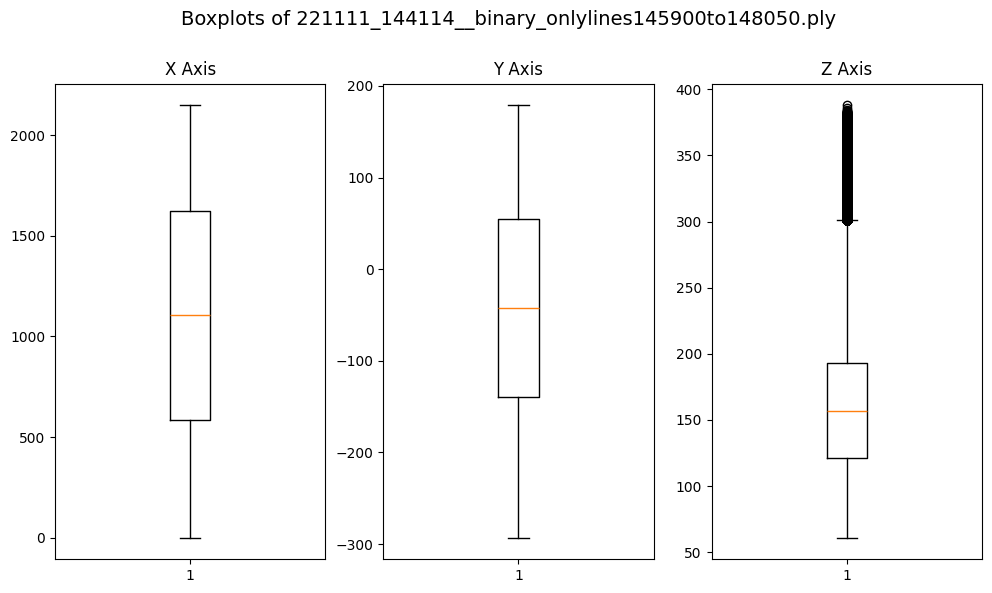

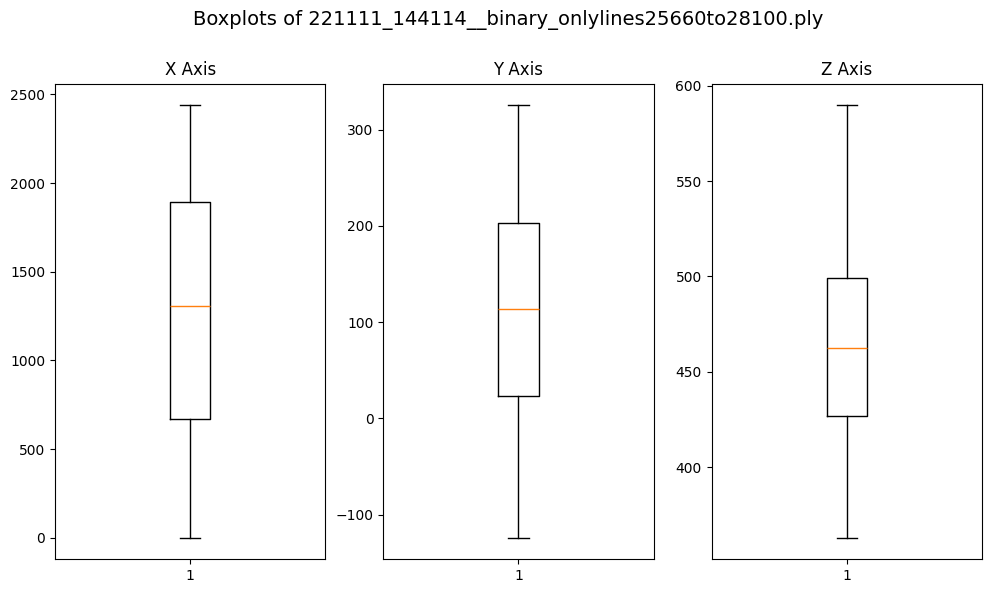

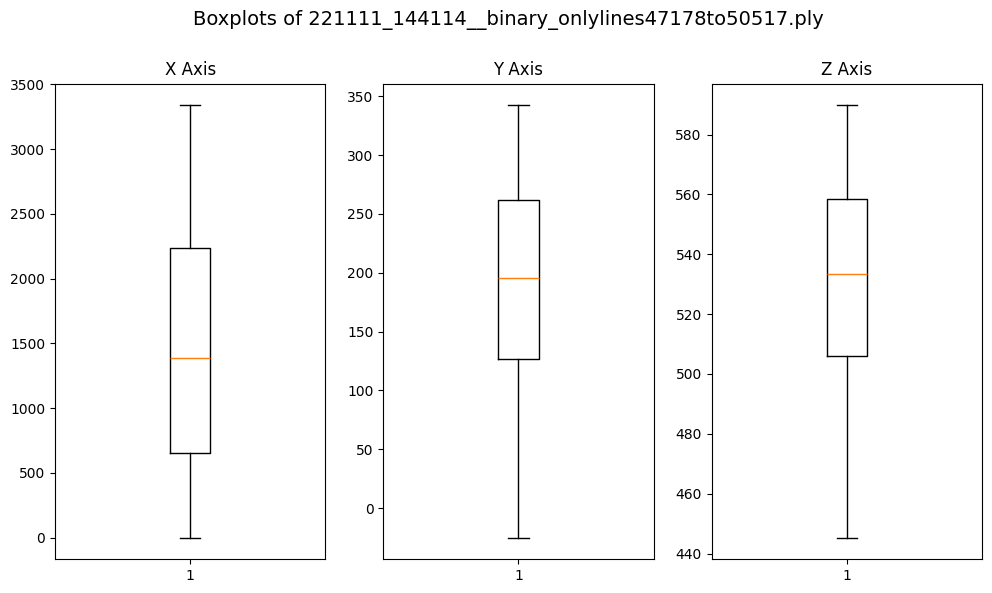

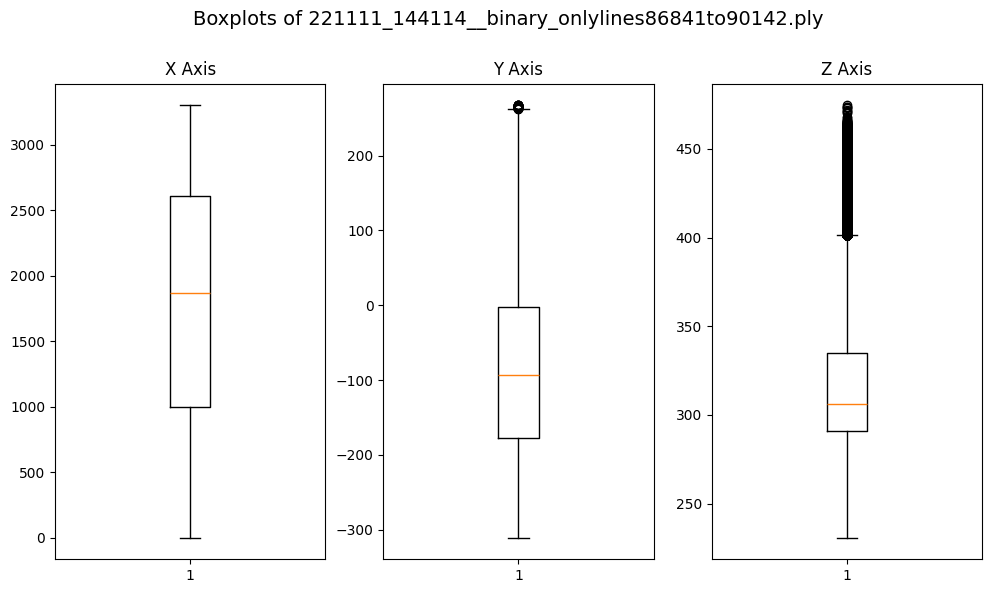

In [ ]:
if (presmoothing_boxplots):
    for i in range(num_of_clouds):
        fig, axs = plt.subplots(1, 3, figsize=(10,6))

        fig.suptitle('Boxplots of ' + ply_file_names[i], fontsize=14)
        plt.tight_layout(rect=[0, 0, 1, 0.95])

        axs[0].boxplot(point_clouds[i][0])
        axs[0].set_title('X Axis')

        axs[1].boxplot(point_clouds[i][1])
        axs[1].set_title('Y Axis')

        axs[2].boxplot(point_clouds[i][2])
        axs[2].set_title('Z Axis')
        plt.show()
else:
    print("Boxplot rendering is disabled.")

Let's render the pointclouds. Can take several minutes.

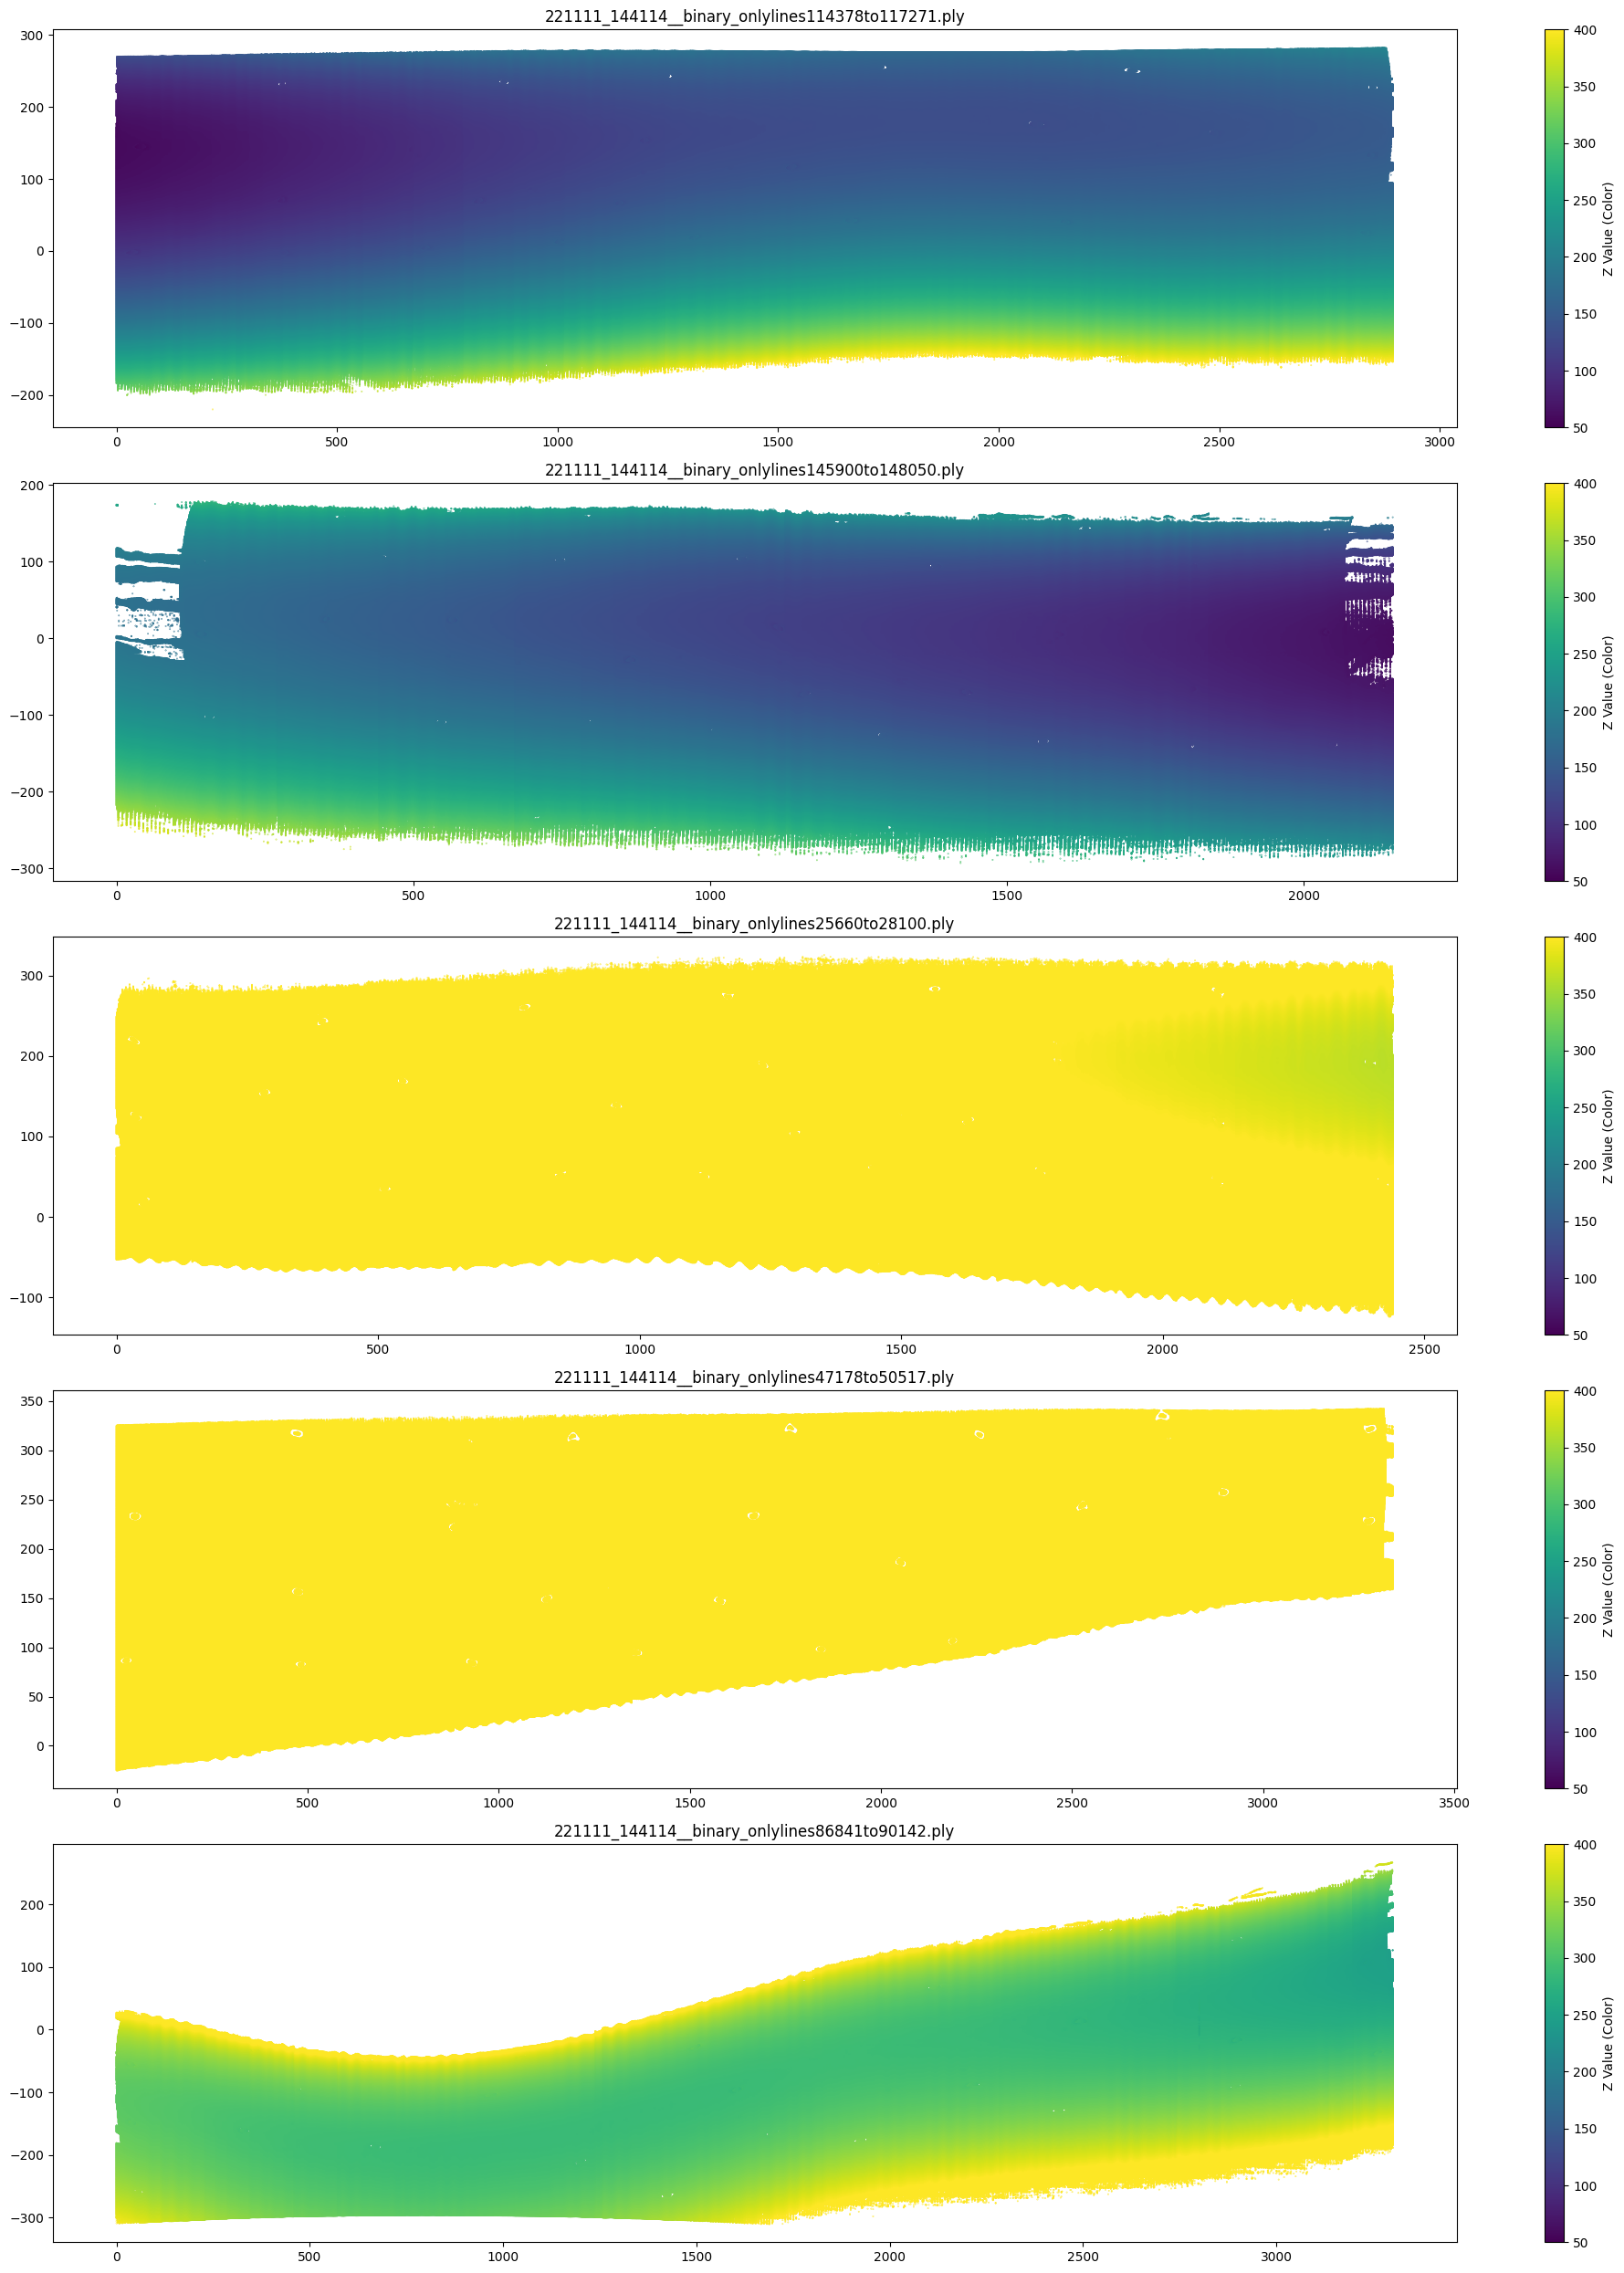

In [9]:
# Create subplots for each point cloud
if(presmoothing_renders):
    fig, axes = plt.subplots(num_of_clouds, 1, figsize=(20, 5*num_of_clouds))

    # If there's only one point cloud, wrap axes in a list
    if num_of_clouds == 1:
        axes = [axes]

    # Loop through each point cloud and plot it in a separate subplot
    for i, pointcloud in enumerate(point_clouds):
        # Unpack x, y, z coordinates
        x, y, z = pointcloud  
        
        # Scatter plot of the point cloud
        sc = axes[i].scatter(x, y, c=z, s=0.1, vmin=50, vmax=400)
        axes[i].set_title(ply_file_names[i])

        # Add colorbar for each subplot
        cbar = plt.colorbar(sc, ax=axes[i])
        cbar.set_label("Z Value (Color)")

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()
else:
    print("Rendering of scans before smoothing is disabled.")

# Smoothing
Now we want, for every unique x-coordinate, to repeat WP1's process:

- Smooth the z-values on y-axis
- Calculate delta between smoothed z-values and actual z-values
- Display the delta

There are 14.127 x-coordinates in total, so that means 14.127 loops doing the above thing. Though we will skip the displaying until later so we only need to graph once.

Smoothing takes about 2 hours to complete, so that's why it is only done once, after which the results are stored in files.

**NOTE**: this `loess_1d` function assigns a weight of 0 to all values >4 standard deviations from the mean. WP1's library of choice does this to *>6* standard deviations. The only way to also use 6 stds is to write the entire function from scratch. That is hard and >4 is probably good enough for our results.

Smoothing point cloud: 221111_144114__binary_onlylines114378to117271.ply
All unique values: [0.000e+00 1.000e+00 2.000e+00 ... 2.891e+03 2.892e+03 2.893e+03]
Amount of unique values: 2894
0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0 16.0 17.0 18.0 19.0 20.0 21.0 22.0 23.0 24.0 25.0 26.0 27.0 28.0 29.0 30.0 31.0 32.0 33.0 34.0 35.0 36.0 37.0 38.0 39.0 40.0 41.0 42.0 43.0 44.0 45.0 46.0 47.0 48.0 49.0 50.0 51.0 52.0 53.0 54.0 55.0 56.0 57.0 58.0 59.0 60.0 61.0 62.0 63.0 64.0 65.0 66.0 67.0 68.0 69.0 70.0 71.0 72.0 73.0 74.0 75.0 76.0 77.0 78.0 79.0 80.0 81.0 82.0 83.0 84.0 85.0 86.0 87.0 88.0 89.0 90.0 91.0 92.0 93.0 94.0 95.0 96.0 97.0 98.0 99.0 100.0 101.0 102.0 103.0 104.0 105.0 106.0 107.0 108.0 109.0 110.0 111.0 112.0 113.0 114.0 115.0 116.0 117.0 118.0 119.0 120.0 121.0 122.0 123.0 124.0 125.0 126.0 127.0 128.0 129.0 130.0 131.0 132.0 133.0 134.0 135.0 136.0 137.0 138.0 139.0 140.0 141.0 142.0 143.0 144.0 145.0 146.0 147.0 148.0 149.0 150.0 151.0 152.0 153.

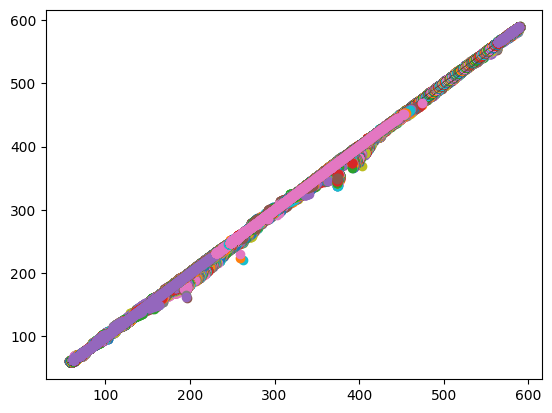

In [14]:
for i in range(num_of_clouds):
    x = point_clouds[i][0]
    y = point_clouds[i][1]
    z = point_clouds[i][2]

    print('Smoothing point cloud:', ply_file_names[i])
    print('All unique values:', np.unique(x))
    print('Amount of unique values:', len(np.unique(x)))
    
    smoothed_z = np.zeros(z.shape)

    for xi in np.unique(x):
        print(xi, end=' ')
        mask = x == xi
        _, smoothed_z[mask], _ = loess_1d.loess_1d(y[mask], z[mask], frac=smoothing_fraction)
        plt.scatter(z[mask], smoothed_z[mask])

    print()
    filename, ext = os.path.splitext(ply_file_names[i])
    filename = filename + f' loess frac={smoothing_fraction}'
    np.save(filename, np.array([x, y, smoothed_z]))
    print('Saved', filename)

Loading a smoothed scans to check that smoothing succeeded.

In [23]:
npy_files = [filename for filename in os.listdir('.') if filename.endswith(".npy")]
smoothed_point_clouds = [np.load(npy_file) for npy_file in npy_files]

num_of_clouds = len(smoothed_point_clouds)
total_rows = 0

print(f"Loaded {num_of_clouds} smoothed point clouds.")

for i in range(num_of_clouds):
    print(f"Smoothed point cloud {npy_files[i]} shape: {smoothed_point_clouds[i].shape}")
    total_rows += smoothed_point_clouds[i].shape[1]
print(f"Total number of rows: {total_rows}")

Loaded 5 smoothed point clouds.
Smoothed point cloud 221111_144114__binary_onlylines114378to117271 loess frac=0.16.npy shape: (3, 5543532)
Smoothed point cloud 221111_144114__binary_onlylines145900to148050 loess frac=0.16.npy shape: (3, 3786525)
Smoothed point cloud 221111_144114__binary_onlylines25660to28100 loess frac=0.16.npy shape: (3, 3535680)
Smoothed point cloud 221111_144114__binary_onlylines47178to50517 loess frac=0.16.npy shape: (3, 3414927)
Smoothed point cloud 221111_144114__binary_onlylines86841to90142 loess frac=0.16.npy shape: (3, 4718054)
Total number of rows: 20998718


Let's create a few plots to look at our data and how it is distributed after smoothing.

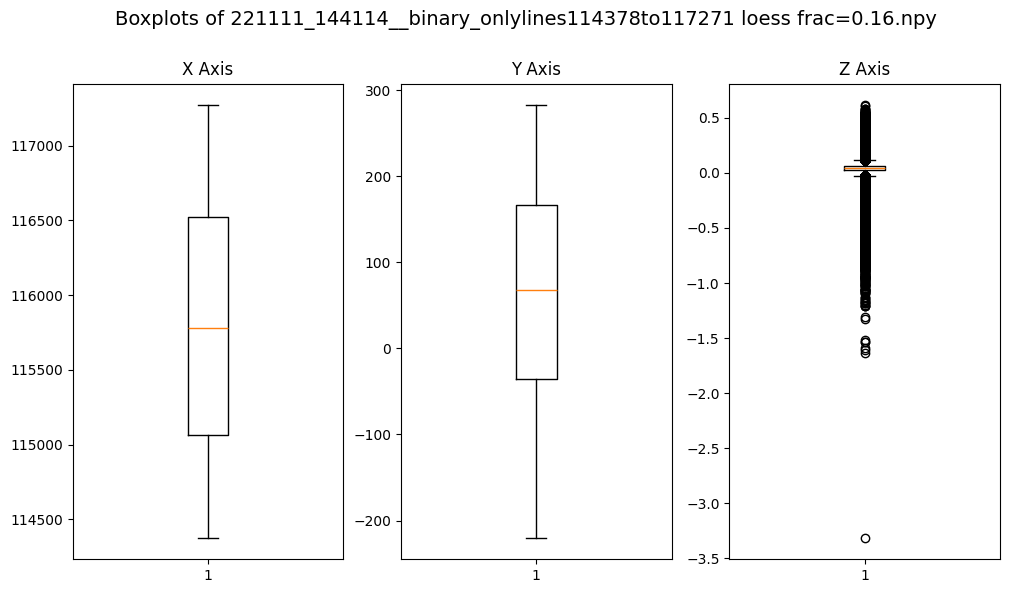

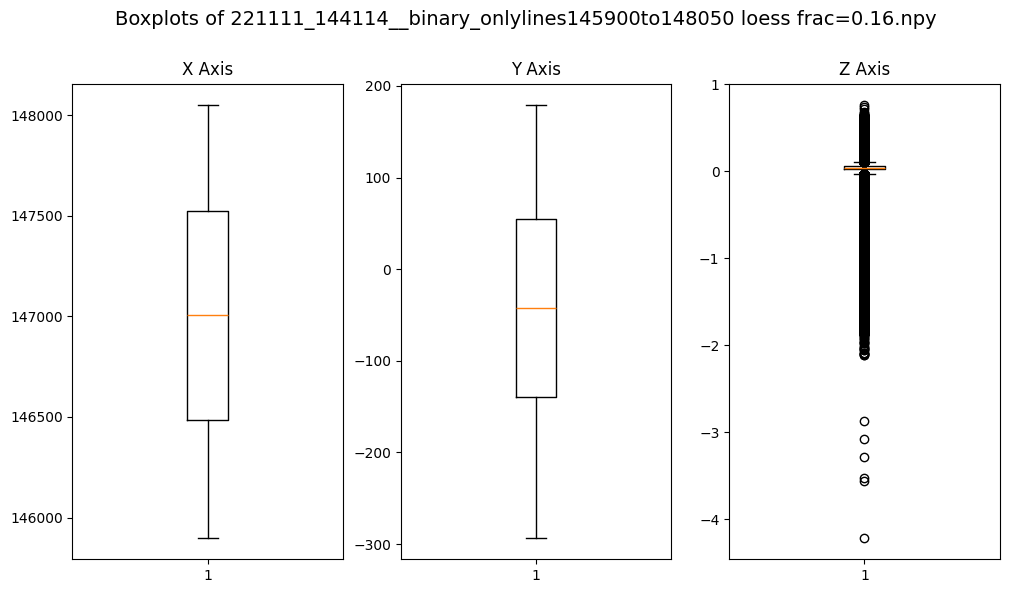

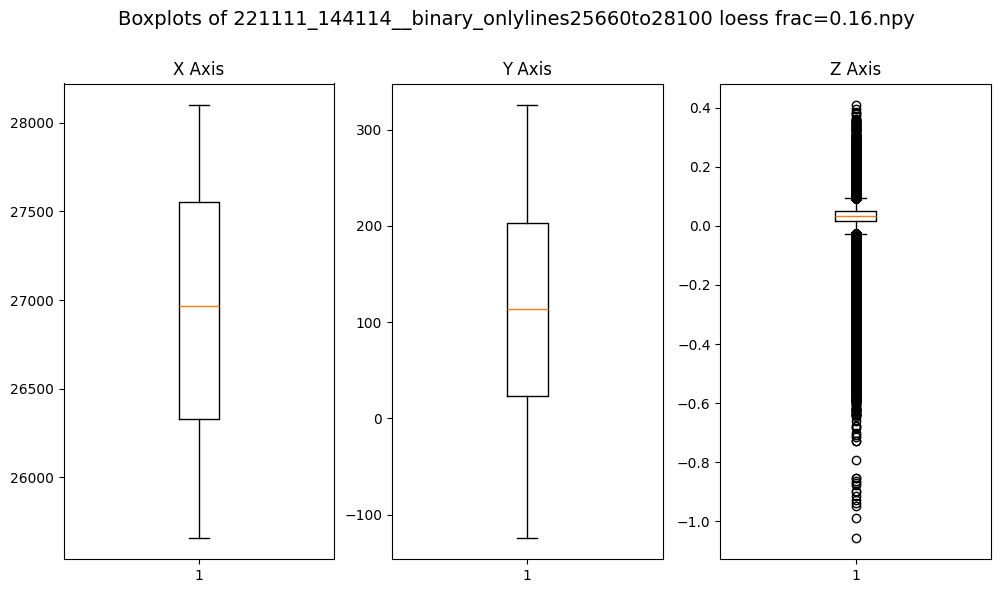

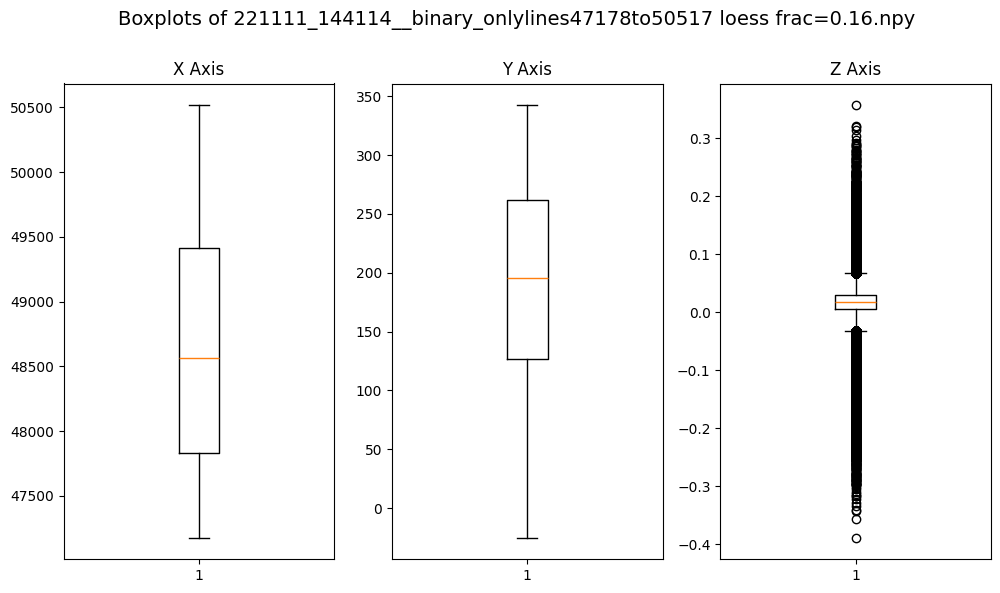

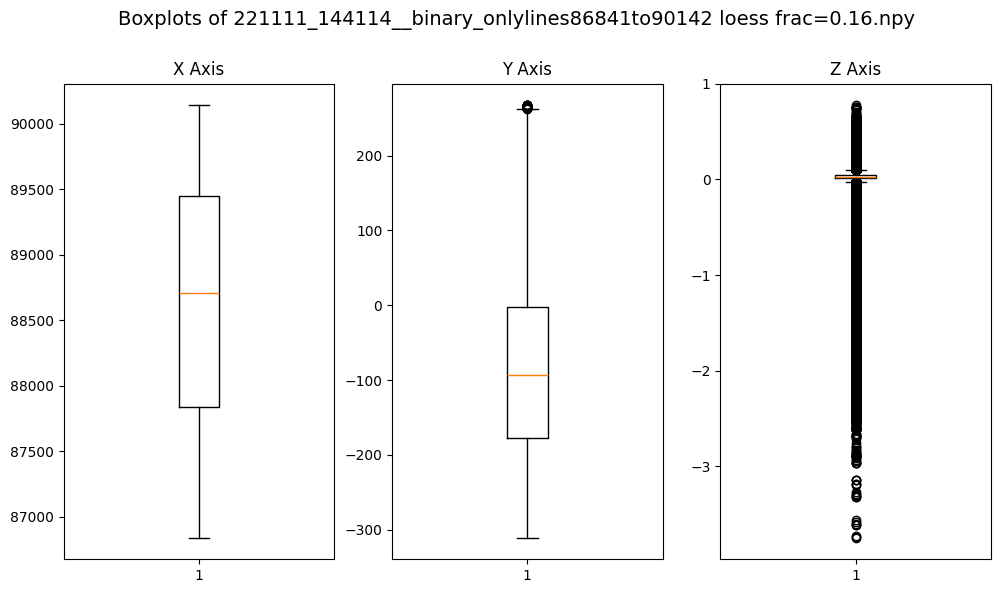

In [29]:
if (postsmoothing_boxplots):
    for i in range(num_of_clouds):
        x, y, z = point_clouds[i]
        smoothed_z = smoothed_point_clouds[i][2]
        result_z = (smoothed_z - z) / 10

        fig, axs = plt.subplots(1, 3, figsize=(10,6))

        fig.suptitle('Boxplots of ' + npy_files[i], fontsize=14)
        plt.tight_layout(rect=[0, 0, 1, 0.95])

        axs[0].boxplot(x)
        axs[0].set_title('X Axis')

        axs[1].boxplot(y)
        axs[1].set_title('Y Axis')

        axs[2].boxplot(result_z)
        axs[2].set_title('Z Axis')
        plt.show()
else:
    print("Boxplot rendering is disabled.")

Rendering difference between smoothed and raw (original) scans. This makes erosion visible, as erosion is really just sudden variations from the surrounding surface of the blade.

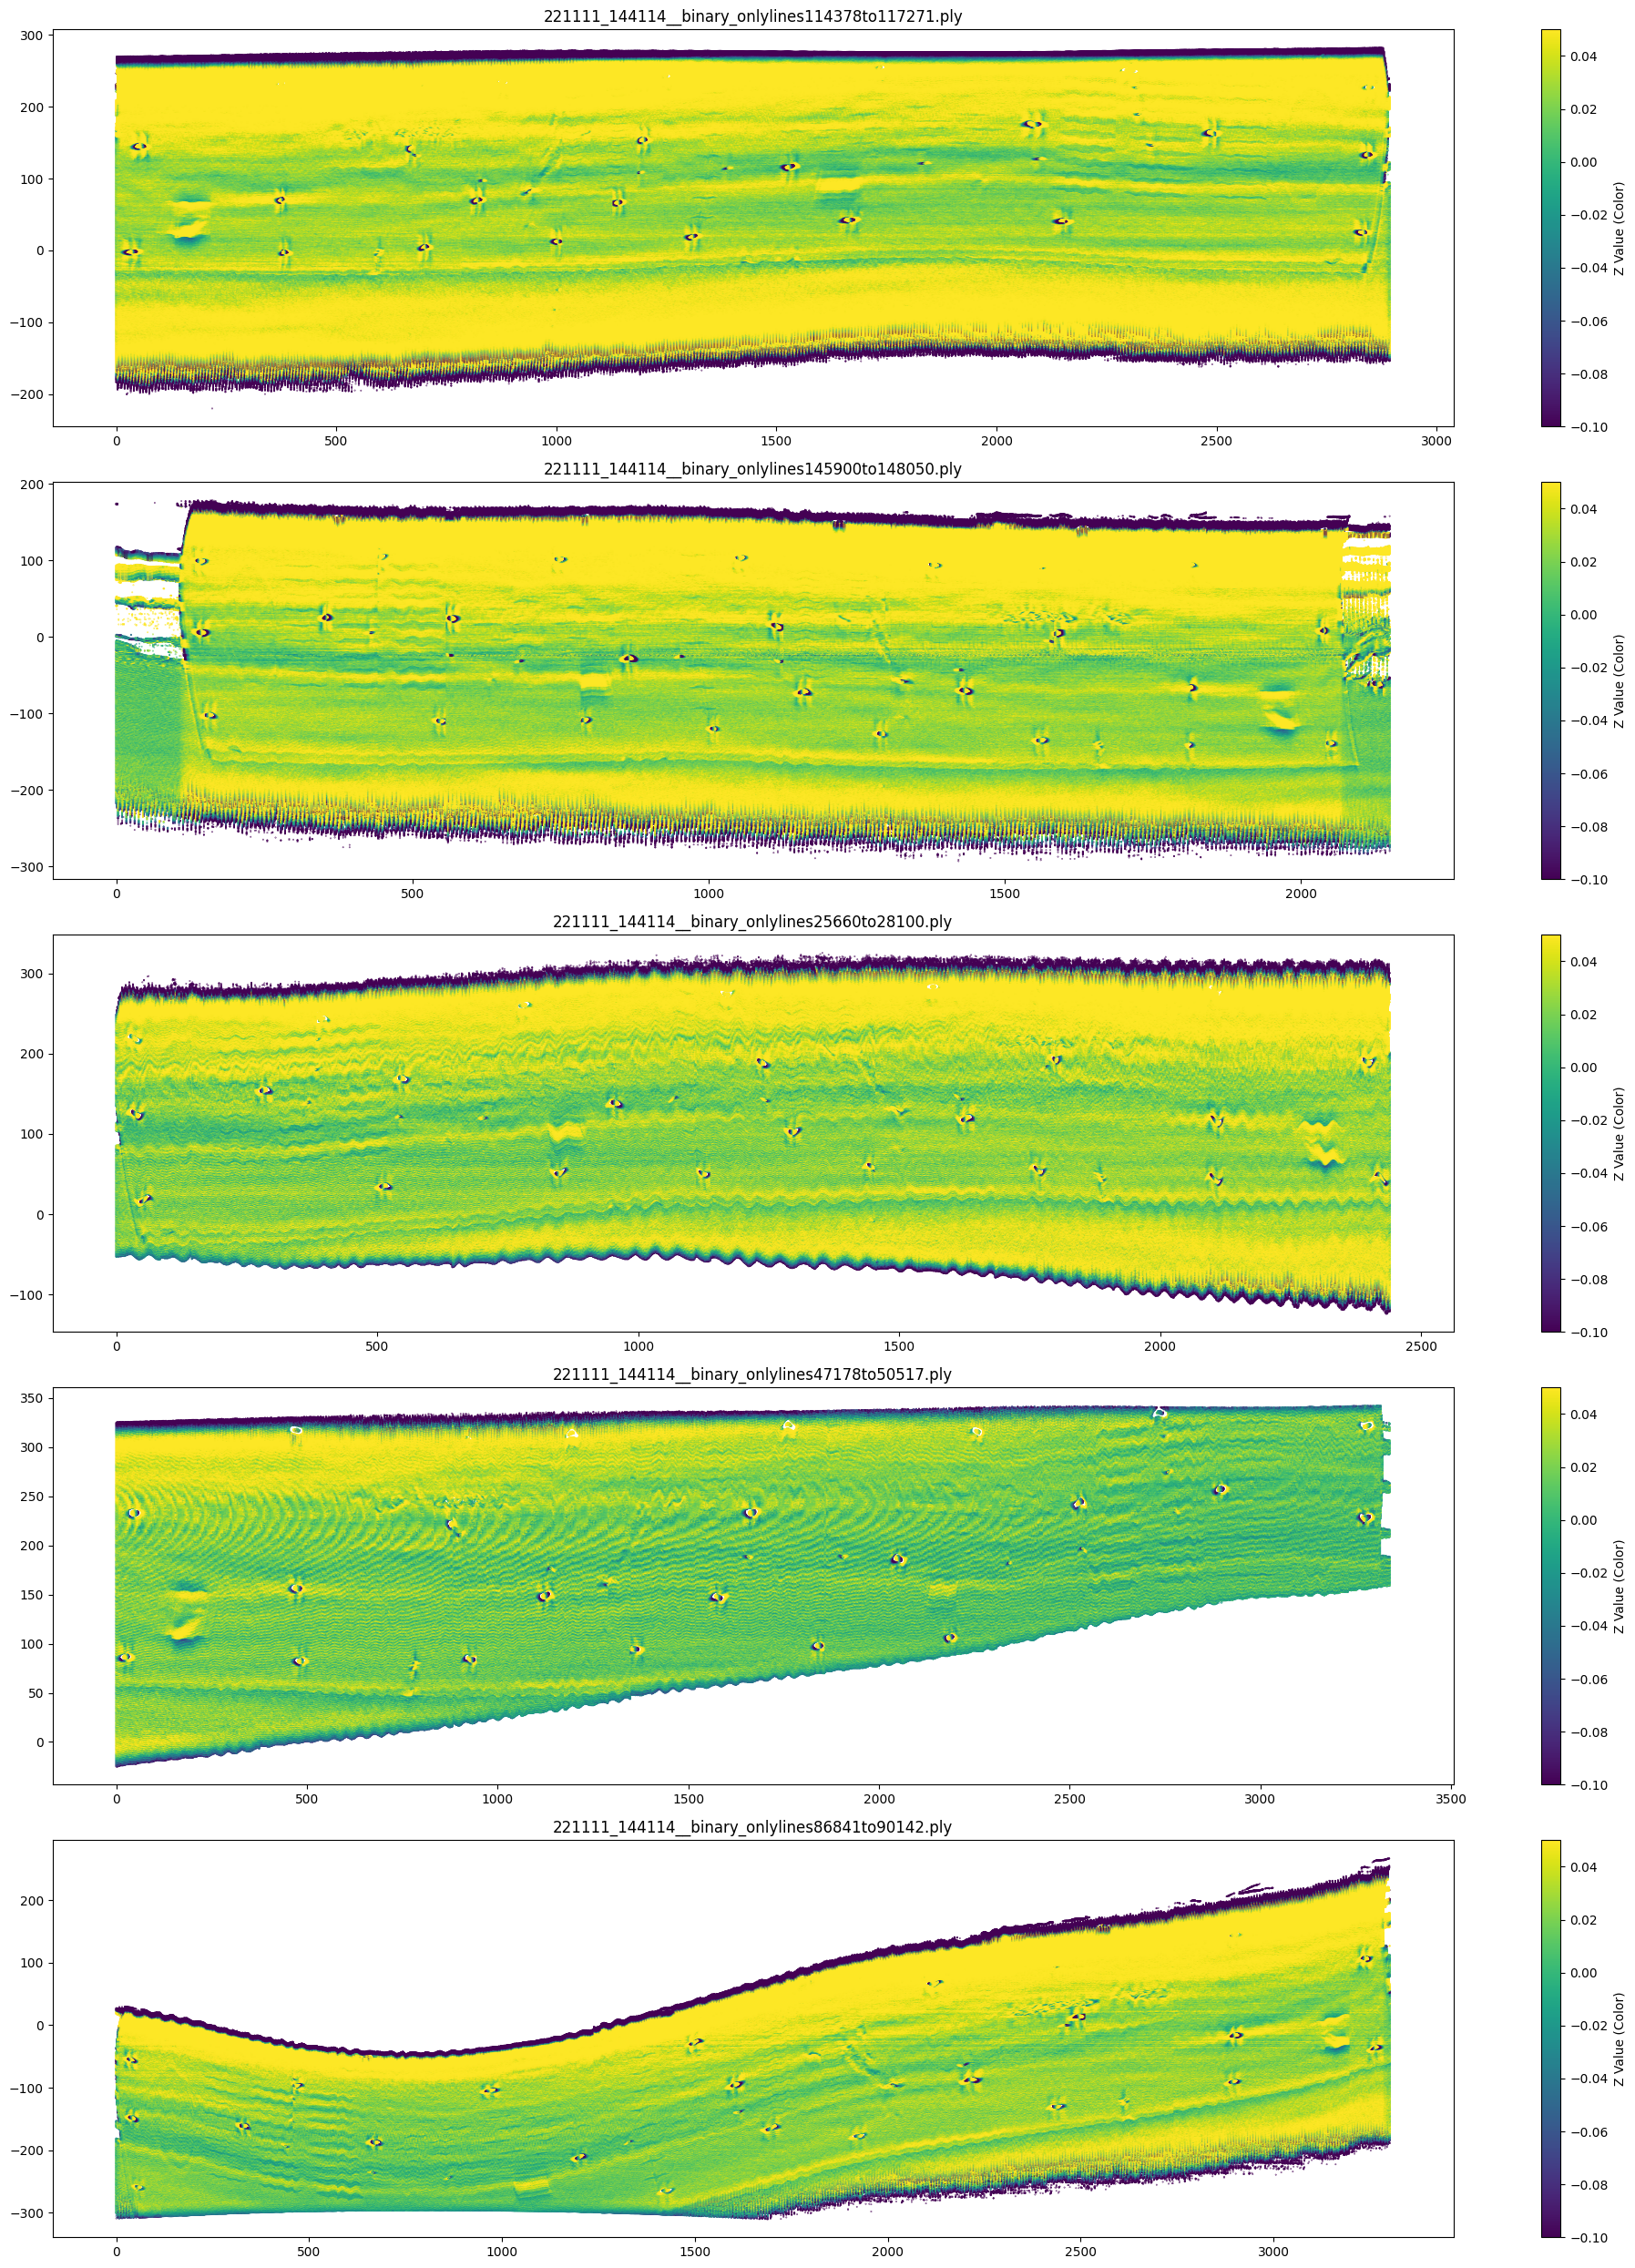

In [ ]:
# Create subplots for each point cloud
if(postsmoothing_renders):
    fig, axes = plt.subplots(num_of_clouds, 1, figsize=(20, 5*num_of_clouds))

    # If there's only one point cloud, wrap axes in a list
    if num_of_clouds == 1:
        axes = [axes]

    # Loop through each point cloud and plot it in a separate subplot
    for i in range(num_of_clouds):
        # Unpack x, y, z coordinates
        x, y, z = point_clouds[i]
        smoothed_z = smoothed_point_clouds[i][2]
        result_z = (smoothed_z - z) / 10
        
        # Scatter plot of the point cloud
        sc = axes[i].scatter(x, y, c=result_z, s=0.1, vmin=-0.1, vmax=0.05)
        axes[i].set_title(ply_file_names[i])

        # Add colorbar for each subplot
        cbar = plt.colorbar(sc, ax=axes[i])
        cbar.set_label("Z Value (Color)")

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()
else:
    print("Rendering of scans after smoothing is disabled.")